# Unemployment rate in SA


## How does different economic factors affect Unemployment rate ?

The purpose of this notebook is to explore variables that could potetially have a relationship with our response variables, i.e unemployment rate.
<br>
<br>
We will first start of by exploring which varibles have a relationship with the unemployment rate then after use those variables to answer the following questions:
<br>
<br>
**Questions:**<br>
1. How does the government cash flow affect unemployment rate?
2. Do investment returns affect the employment rate?
3. How does the government assets affect unemployment rate?
4. How does the government debt affect unemployment rate?
<br>
<br>
We will explore this relationship using the regression slope test that has a regression line of the format:
<br>
$$
Y=\beta_{i} X \ for \ i = 0,1,2...m
$$
Where $X$ are the selected variables and $\beta_{i}$ are the respective coefficients.Thus, the **hypothesis** is as follows:
$$
\begin{array}{l}{\mathrm{H}_{\mathrm{0}} : \beta_{0}=\beta_{1}=...=\beta_{m}=0} \\ {\mathrm{H}_{\mathrm{1}} : \beta_{i} \neq 0 } \ for \ at \ least\ one \ i\end{array}
$$

<br>
<br>
We will be using the $F$-test to simultaneously check the significance of a number of regression coefficients.

In [89]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.metrics import r2_score
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from statsmodels.formula.api import rlm
import statsmodels.api as sm
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
import re
import string

# Data Collection

### South African Reserve Bank Cleaned Economic Data

Data prepared for modelling from the South African Reserve Bank

This data can used for both regression and classification research questions i.e. forecast the unemployment rate.

The original data was sourced from https://www.resbank.co.za/en/home/what-we-do/statistics/releases/economic-and-financial-data-for-south-africa


### The full feature set
*These feature were accessed from the South African Reserve Bank.*

*There are **147 features in total**, these cover a significant portfion of the South African economy*

**The data from 1922-01-01 to 2020-01-01** if it used for unemployment forecasting, deleting redudant observations is helpful

In [2]:
feature_set_sarb = pd.read_csv('sarb_features_data.csv').set_index('Date')
target = pd.read_csv('sarb_target_data.csv').set_index('Date')

# Data Preparation

## Missing Data 

The missing data occurs because we are merging data that is monthly and data that is quartely, hence all quartely data should be expected to have missing data. This is normal when dealing with multiple time series.

In [3]:
#Here we visualize the frequency of missingness of each feature
feature = feature_set_sarb.isna().sum()/len(feature_set_sarb)

feature = feature.sort_values(ascending=False)
feature_df = pd.DataFrame(feature.index, columns=['Feature Name'])
feature_df['Missing Frequency'] = np.array(feature.values)
feature_df['Rank'] = feature_df['Missing Frequency'].rank(ascending=False)
#feature_df
feature_df

,Feature Name,Missing Frequency,Rank
0,Loans _y,0.986732,1.0
1,Consolidated general government: Liabilities: ...,0.959497,2.0
2,The difference between cash-flow revenue and c...,0.958799,3.0
3,Total South African population,0.958101,4.0
4,Foreign debt of S.A.: Total foreign debt,0.953212,5.0
...,...,...,...
143,Total outstanding foreign marketable bonds by ...,0.497207,133.0
144,Net foreign assets after valuation adjustment,0.497207,133.0
145,Total foreign non-marketable debt,0.497207,133.0
146,Foreign exchange rate : SA rand per USA dollar,0.496508,147.0


<BarContainer object of 148 artists>

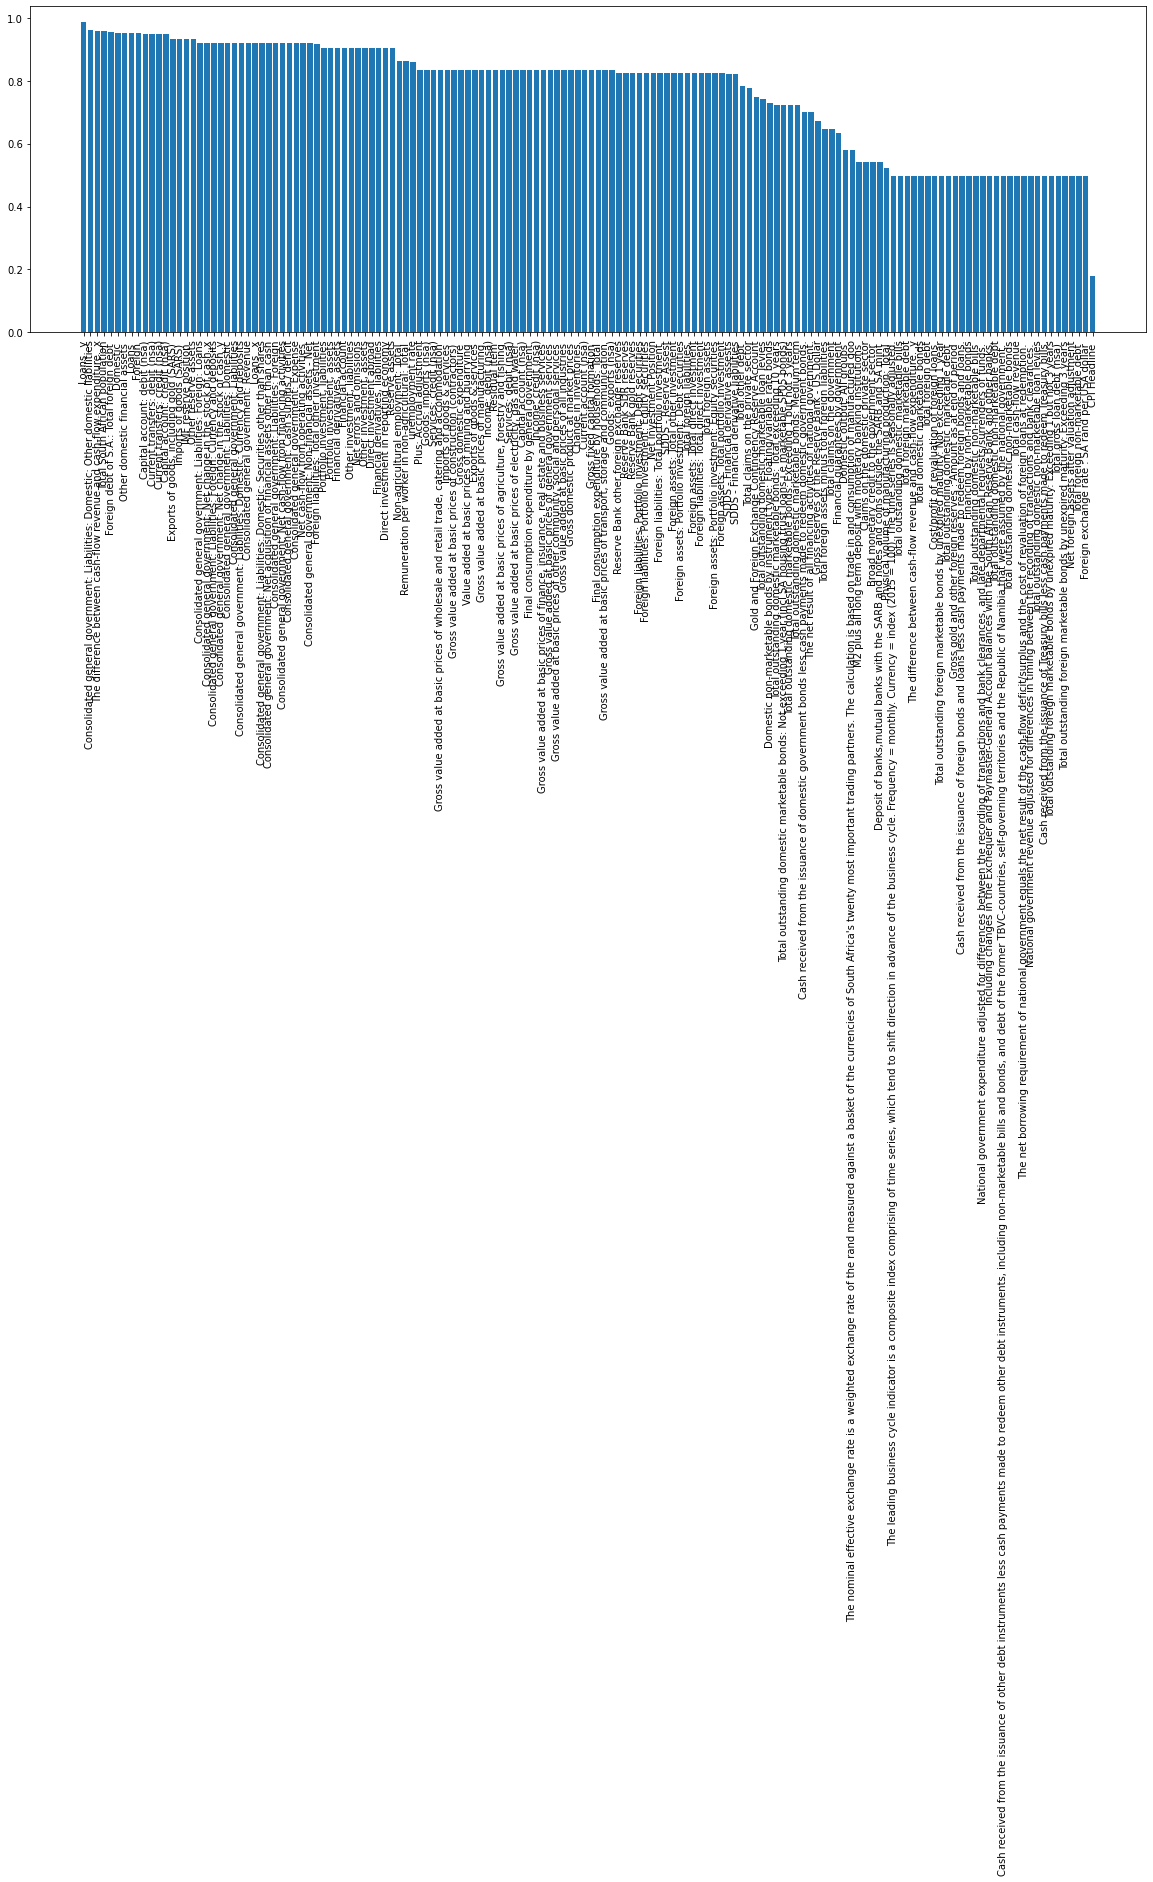

In [4]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
plt.bar(feature_df['Feature Name'], feature_df['Missing Frequency'])

## Imputation

In [5]:
# Data imputation strategy is foward fill i.e last know value imputation
# Economic data usually does not change that much from month to month.
x_values_ffill = feature_set_sarb.fillna(method='ffill')
y_values_ffill = target.fillna(method='ffill')

In [6]:
# Remove all data points before unemployment rate data is available. Unemployment rate is my target variable.
valid_start = y_values_ffill.first_valid_index()
y_values_ffill = y_values_ffill[valid_start : ]
x_values_ffill = x_values_ffill[valid_start : ]

In [7]:
#We fill with NA here to avoid any features that might be NA i.e. insurance
x_values_ffill = x_values_ffill.fillna(0)
x_values_ffill.isna().sum()

Final consumption expenditure by general government             0
Consolidated general government: Revenue                        0
Foreign liabilities: Total portfolio investment                 0
Foreign liabilities: Portfolio investment: Equity securities    0
Domestic output: All groups                                     0
                                                               ..
Net cash-flow from operating activities                         0
Non-agricultural employment: Total                              0
Consolidated general government: Expense                        0
Residual item                                                   0
unemployment rate                                               0
Length: 148, dtype: int64

# Helper functions

In [8]:
def model_fit(X,y):    
    #no of features
    feature_list=np.arange(1, len(X.columns))            
    high_score=0
    #Variable to store the optimum features
    optimum_no_featurcashes=0           
    score_list =[]
    for n in range(len(feature_list)):
        model = LinearRegression()
        rfe = RFE(model,feature_list[n])
        X_train_rfe = rfe.fit_transform(X,y)
        model.fit(X_train_rfe,y)
        # R2 score for measurement
        score = r2_score(y, model.predict(X_train_rfe))
        score_list.append(score)
        
        if n % 10 == 0:
            print(n,score)
            
        if(score>high_score):
            high_score = score  
            optimum_no_features = feature_list[n]
    return score_list, optimum_no_features 

In [9]:
def plt_plot(values,title, x_label, y_label):
    
    plt.plot(values)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

In [10]:
def final_model(optimum_no_features, X_train, y_train,cols):
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, optimum_no_features)             
    #Transforming data using RFE
    x_fitted = rfe.fit_transform(X_train,y_train)  
    #Fitting the data to model
    model.fit(x_fitted,y_train)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

In [11]:
def print_p_values(x_test, y_test, predicted, params):
    """
    Calculates the p value, based on https://stackoverflow.com/a/42677750/9260653
    """
    newX = np.append(np.ones((len(x_test),1)), x_test, axis=1)
    MSE = (sum((y_test.values-predicted)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)[:-1]
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-Values"] = [params,sd_b,ts_b,p_values]
    print(myDF3.iloc[1])

# Unemployment rate in SA :

##  1. How does the government assets affect unemployment rate?

## Features relating to assets

### Get features associated with assests

In [12]:
df_out = list()
for i in x_values_ffill:
    if 'assets' in i:
        df_out.append(i)
df_out.append("unemployment rate")
df_out #7

['Other domestic financial assets ',
 'Foreign assets: Total other investment',
 'Foreign assets: Portfolio investment: Debt securities',
 'Foreign assets: Total direct investment',
 'Reserve assets',
 'Total foreign assets',
 'Other reserve assets',
 'Foreign assets: Total portfolio investment',
 'Foreign assets: Portfolio investment: Equity securities',
 'Other investment, assets',
 'Financial derivatives, assets',
 'Total foreign assets minus total foreign liabilities',
 'Net foreign assets after valuation adjustment',
 'Portfolio investment, assets',
 'Consolidated general government: Net acquisition of financial assets other than cash',
 'Consolidated general government: Non-financial assets - Net',
 'unemployment rate']

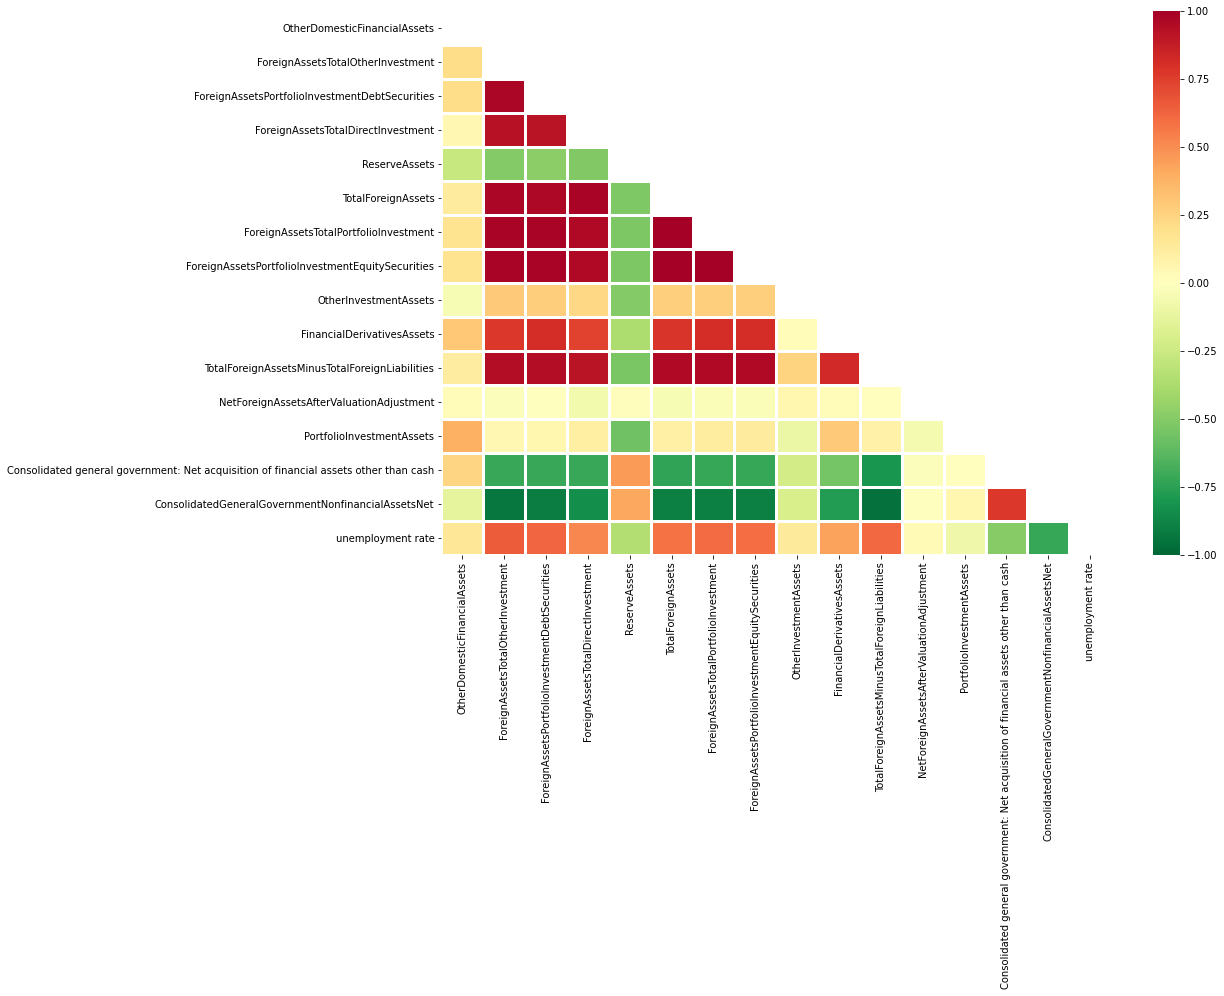

In [13]:
df_assets2 = x_values_ffill[df_out]
df_assets2.rename(columns={'Portfolio investment, assets':'PortfolioInvestmentAssets',
        'Foreign assets: Portfolio investment: Debt securities': 'ForeignAssetsPortfolioInvestmentDebtSecurities',
                        'Consolidated general government: Non-financial assets - Net':'ConsolidatedGeneralGovernmentNonfinancialAssetsNet',
                          'Foreign assets: Total other investment': 'ForeignAssetsTotalOtherInvestment',
                          'Foreign assets: Total direct investment': 'ForeignAssetsTotalDirectInvestment',
                          'Other investment, assets':'OtherInvestmentAssets',
                          'Financial derivatives, assets':'FinancialDerivativesAssets',
                           'Foreign assets: Portfolio investment: Equity securities': 'ForeignAssetsPortfolioInvestmentEquitySecurities',
                          'Other domestic financial assets ':'OtherDomesticFinancialAssets',
                          'Total foreign assets':'TotalForeignAssets',
                          'Total foreign assets minus total foreign liabilities':'TotalForeignAssetsMinusTotalForeignLiabilities',
                          'Net foreign assets after valuation adjustment':'NetForeignAssetsAfterValuationAdjustment',
                          'Foreign assets: Total portfolio investment':'ForeignAssetsTotalPortfolioInvestment',
                          'Reserve assets':'ReserveAssets'}
                  , inplace=True)
del df_assets2["Other reserve assets"]
corr_df = df_assets2.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,10))


mask=np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr_df,cmap='RdYlGn_r',vmax=1.0,vmin=-1.0,mask=mask,linewidths=2.5,ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

It appears most of the assets are positively correlated with unemployment rate, however, there is also strong correlation between some assets which may lead to problem of colinearity

#### Here I am separating features from the target variable

In [14]:
X= df_assets2
del X["unemployment rate"]
df2 = y_values_ffill.rename(columns={'unemployment rate':'unemployment_rate'})

y = df2['unemployment_rate']

Earlier on, we saw that some of our fetaures we strongly correlated that could cause issue of multicollinearity, to resolve that, I shall optimize my feature space by removing features with correlation more than 0.8 .

In [15]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
len(correlated_features)


9

In [16]:
print(correlated_features)

{'Consolidated general government: Net acquisition of financial assets other than cash', 'TotalForeignAssetsMinusTotalForeignLiabilities', 'TotalForeignAssets', 'ForeignAssetsTotalPortfolioInvestment', 'ConsolidatedGeneralGovernmentNonfinancialAssetsNet', 'ForeignAssetsPortfolioInvestmentEquitySecurities', 'ForeignAssetsTotalDirectInvestment', 'ForeignAssetsPortfolioInvestmentDebtSecurities', 'FinancialDerivativesAssets'}


In [17]:
X.drop(labels=correlated_features, axis=1, inplace=True)
X.shape

(794, 6)

Having obtained the optimized features, below we select them and in our new dataset and plot the correlation matrix.

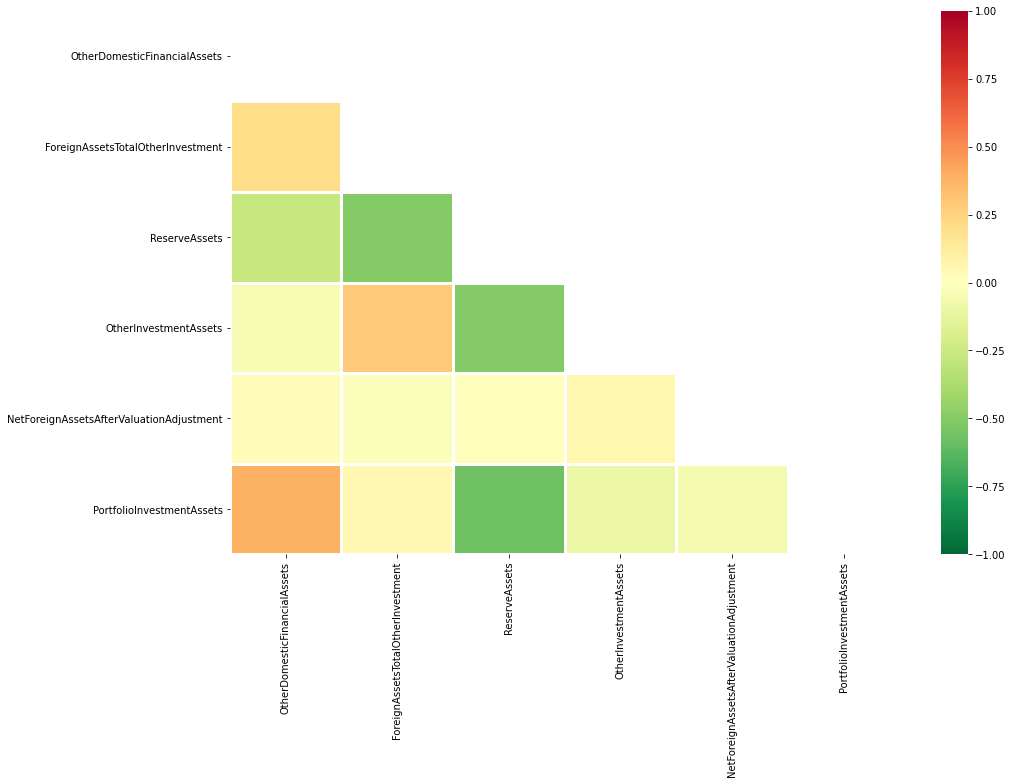

In [18]:
corr_df = X.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,10))


mask=np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr_df,cmap='RdYlGn_r',vmax=1.0,vmin=-1.0,mask=mask,linewidths=2.5,ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

## Partitioning the Data into Training(70%) and Testing(30%) sets


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [20]:
X_train

,OtherDomesticFinancialAssets,ForeignAssetsTotalOtherInvestment,ReserveAssets,OtherInvestmentAssets,NetForeignAssetsAfterValuationAdjustment,PortfolioInvestmentAssets
Date,,,,,,
1976-08-01,0.0,2.0,0.0,0.0,-77.0,0.0
1991-01-12,0.0,7.0,88.0,502.0,1601.0,-159.0
1996-04-01,0.0,18.0,-752.0,-3779.0,-4505.0,-1575.0
1976-01-06,0.0,0.0,0.0,0.0,-243.0,0.0
2006-10-01,8839.0,247.0,-7721.0,3952.0,-17016.0,-4469.0
...,...,...,...,...,...,...
2018-01-03,-18450.0,528.0,14571.0,-21611.0,-17360.0,-15948.0
1982-03-01,0.0,3.0,0.0,0.0,-895.0,0.0
2009-08-01,-14320.0,251.0,-2288.0,846.0,22247.0,-9649.0


## Modelling phase

### The following function applies step wise linear regression fit to our model

In [21]:
scores_list, optimum_no_features = model_fit(X_train,y_train)
print(optimum_no_features)

0 0.4245171785921674
5


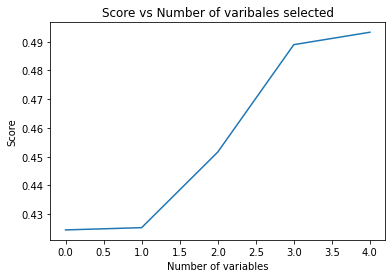

In [22]:
plt_plot(scores_list, 'Score vs Number of varibales selected','Number of variables', 'Score')

### Final model which utilizes optimum number of features, which were returned by the above function

In [23]:
cols_assets = list(X.columns)

selected_features, model, rfe = final_model(optimum_no_features, X_train, y_train,cols_assets)
print(selected_features)

Index(['OtherDomesticFinancialAssets', 'ForeignAssetsTotalOtherInvestment',
       'ReserveAssets', 'OtherInvestmentAssets', 'PortfolioInvestmentAssets'],
      dtype='object')


From our stepwise linear regression we have ended with 5 features only 1 redundant one was removed

Now model prediction

In [24]:
y_train_predicted = model.predict(rfe.transform((X_train)))

### Model Analysis


## Post-Stepwise Regression


### Residual analysis


In [25]:
residuals =y_train.astype(float)- (y_train_predicted)

<AxesSubplot:xlabel='unemployment_rate'>

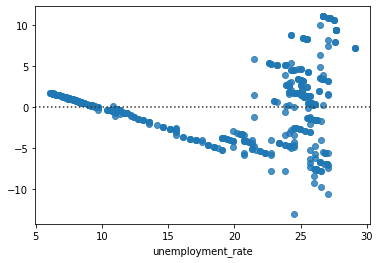

In [26]:
sns.residplot(y_train.astype(float),y_train_predicted)

In [27]:
import statsmodels.formula.api as sm

In [28]:
formula_features = ' + '.join(list(selected_features))
formula = 'unemployment_rate~'+ formula_features
formula

'unemployment_rate~OtherDomesticFinancialAssets + ForeignAssetsTotalOtherInvestment + ReserveAssets + OtherInvestmentAssets + PortfolioInvestmentAssets'

In [29]:
# Add y back to df

X_y_new_train = pd.concat([X_train,pd.DataFrame(y_train)], axis=1)

In [30]:
X_train_y_target = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
X_train_y_target

,OtherDomesticFinancialAssets,ForeignAssetsTotalOtherInvestment,ReserveAssets,OtherInvestmentAssets,NetForeignAssetsAfterValuationAdjustment,PortfolioInvestmentAssets,unemployment_rate
Date,,,,,,,
1976-08-01,0.0,2.0,0.0,0.0,-77.0,0.0,6.13100
1991-01-12,0.0,7.0,88.0,502.0,1601.0,-159.0,13.56330
1996-04-01,0.0,18.0,-752.0,-3779.0,-4505.0,-1575.0,20.69500
1976-01-06,0.0,0.0,0.0,0.0,-243.0,0.0,6.27541
2006-10-01,8839.0,247.0,-7721.0,3952.0,-17016.0,-4469.0,25.89860
...,...,...,...,...,...,...,...
2018-01-03,-18450.0,528.0,14571.0,-21611.0,-17360.0,-15948.0,26.70000
1982-03-01,0.0,3.0,0.0,0.0,-895.0,0.0,7.18285
2009-08-01,-14320.0,251.0,-2288.0,846.0,22247.0,-9649.0,23.20000


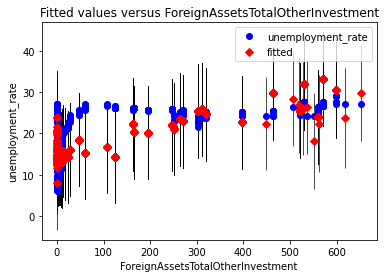

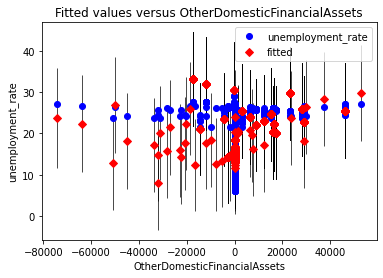

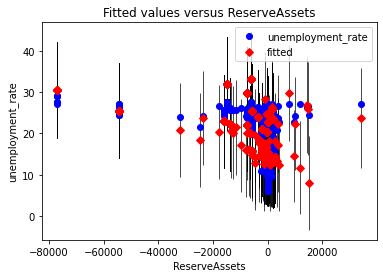

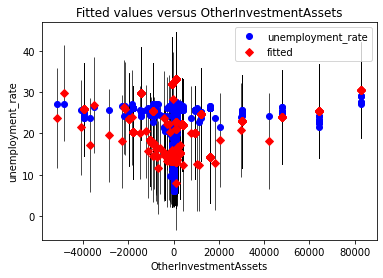

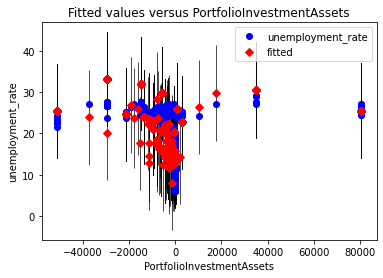

In [31]:
results = sm.ols(formula=formula,data = X_train_y_target).fit()
import statsmodels.graphics as smgraphics

axss = smgraphics.regressionplots.plot_fit(results, 2)
_ = smgraphics.regressionplots.plot_fit(results, 1)
_ = smgraphics.regressionplots.plot_fit(results, 3)
_ = smgraphics.regressionplots.plot_fit(results, 4)
_ = smgraphics.regressionplots.plot_fit(results, 5)

In [32]:
Y_ols_pred=results.predict(X_train)

In [33]:
residuals = y_train - Y_ols_pred


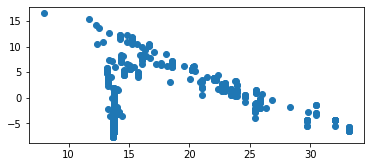

In [34]:
pred_val = results.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(6,2.5))


_ = ax.scatter(pred_val, residuals)

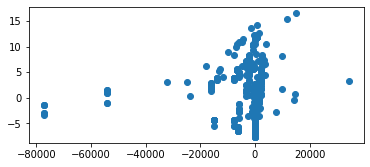

In [35]:
fig, ax1 = plt.subplots(figsize=(6,2.5))
_ = ax1.scatter(X_train.iloc[:,2:3], residuals)

#### Error distribution of residuals

<AxesSubplot:ylabel='Density'>

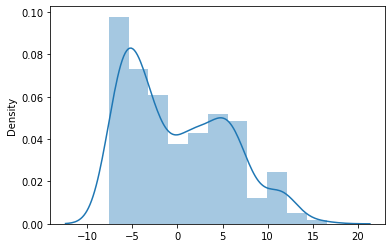

In [36]:
sns.distplot(residuals)

#### QQ plots of sample quantiles vs theoretical ones

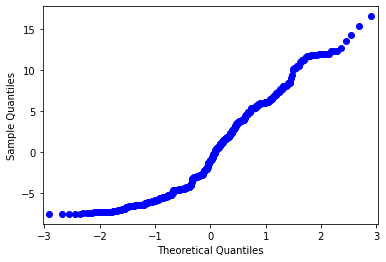

In [37]:
import statsmodels.api as sm
_ = sm.qqplot(residuals)

### Outlier removal


In [38]:
test = results.outlier_test()
outliers = ((x[i],y[i]) for i,t in enumerate(test) if t[2] < 0.5)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)


In [40]:
outliers =(i for i,t in enumerate(test.iloc[:,2]) if t < 0.5)

In [41]:
# Index of Outliers
outliers_list = list(outliers)

In [42]:
# Remove outliers
X_train = pd.DataFrame(np.delete(X_train.values, outliers_list,0))
y_train = pd.DataFrame(np.delete(y_train.values, outliers_list,0))
len(X_train)

555

## Final Model

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

final_model = rlm(formula, data=X_train_y_target,
                      M=sm.robust.norms.HuberT()).fit()

In [44]:
X_train

,OtherDomesticFinancialAssets,ForeignAssetsTotalOtherInvestment,ReserveAssets,OtherInvestmentAssets,NetForeignAssetsAfterValuationAdjustment,PortfolioInvestmentAssets
Date,,,,,,
1976-08-01,0.0,2.0,0.0,0.0,-77.0,0.0
1991-01-12,0.0,7.0,88.0,502.0,1601.0,-159.0
1996-04-01,0.0,18.0,-752.0,-3779.0,-4505.0,-1575.0
1976-01-06,0.0,0.0,0.0,0.0,-243.0,0.0
2006-10-01,8839.0,247.0,-7721.0,3952.0,-17016.0,-4469.0
...,...,...,...,...,...,...
2018-01-03,-18450.0,528.0,14571.0,-21611.0,-17360.0,-15948.0
1982-03-01,0.0,3.0,0.0,0.0,-895.0,0.0
2009-08-01,-14320.0,251.0,-2288.0,846.0,22247.0,-9649.0


In [45]:
final_model_predicted = final_model.predict(X_test)

In [46]:
params = np.array(final_model.params)

In [47]:
metrics.r2_score(y_test, final_model_predicted)

0.5018729659508254

In [48]:
print_p_values(X_test, y_test, final_model_predicted, params)


Coefficients       0.0001
Standard Errors    0.0000
t values           2.3140
P-Values           0.0220
Name: 1, dtype: float64


The test for $H_{0}$ by using the following statistic:
$$
F_{0} = \frac{MS_R}{MS_E}
$$
where $MS_R$ is the regression mean square and $MS_E$ is the error mean square.
<br>
The null hypothesis, $H_{0}$, is rejected if the calculated statistic. $f_{0}, is usch that$
$$
F_{0} > f
$$
I will now test my hypothesist using $F$

In [49]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The fvalue is " + str(fvalue[0][0]))

In [50]:
fstat_test(final_model)

The fvalue is 110.53373551242575


In [51]:
degresOfFreedom = len(X_train) - (len(X_train.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

3.0121687848368994

As shown above, $F_{0} = 110.5337$ and $f = 3.0121$.
<br>
<br>
Since $F_0$ > $f$, $H_{0}$ is rejected and it is concluded that at least one $\beta_{i}$ cofficient is significant. In other words, it is concluded that a regression model exists between the exploratory and response variables

# Unemployement rate in SA: Investigating the relationship between governments profits/losses on investments and unemployment rate in South Africa

## Do investment returns affect the employment rate?

Features about the government's investments were collected from the remaining features with no multi collinearity

In [52]:
def get_inv_features(a, b):
    df_new = list()
    x_col = x_values_ffill.columns.tolist()
    for i in x_col:
        if a in i:
            df_new.append(x_values_ffill[i])
            print(i)
        if b in i:
            df_new.append(x_values_ffill[i])
            print(i)
    return df_new

In [53]:
df_inv = get_inv_features('evalua', 'nvest') 
DF_INV = pd.DataFrame(data = df_inv)

Foreign liabilities: Total portfolio investment 
Foreign liabilities: Portfolio investment: Equity securities
Foreign liabilities: Portfolio investment: Debt securities
Net Investment Position
Foreign liabilities: Total other investment
Foreign assets: Total other investment
Foreign assets: Portfolio investment: Debt securities
The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. 
Foreign assets: Total direct investment
Other investment, liabilities
Foreign assets: Total portfolio investment
Foreign assets: Portfolio investment: Equity securities
Other investment, assets
Cost/profit of revaluation of foreign loans 
Portfolio investment, liabilities
Foreign liabilities: Total direct investment
Direct investment abroad
Portfolio investment, assets
Direct investment in reporting economy


In [54]:
X_INV= DF_INV.transpose()
df2 = df2.rename(columns={'unemployment rate':'unemployment_rate'})
y_inv = df2['unemployment_rate']
X_INV.columns.tolist()

['Foreign liabilities: Total portfolio investment ',
 'Foreign liabilities: Portfolio investment: Equity securities',
 'Foreign liabilities: Portfolio investment: Debt securities',
 'Net Investment Position',
 'Foreign liabilities: Total other investment',
 'Foreign assets: Total other investment',
 'Foreign assets: Portfolio investment: Debt securities',
 'The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. ',
 'Foreign assets: Total direct investment',
 'Other investment, liabilities',
 'Foreign assets: Total portfolio investment',
 'Foreign assets: Portfolio investment: Equity securities',
 'Other investment, assets',
 'Cost/profit of revaluation of foreign loans ',
 'Portfolio investment, liabilities',
 'Foreign liabilities: Total direct investment',
 'Direct investment abroad',
 'Portfolio investment, assets',
 'Direct investment in reporting economy']

In [55]:
def wordopt(text):
    text = text.lower() 
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [56]:
correlated_features = set()
correlation_matrix = X_INV.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
len(correlated_features)


9

In [57]:
X_INV.drop(labels=correlated_features, axis=1, inplace=True)
X_INV.shape

(794, 10)

In [58]:
for col in X_INV.columns:
    new_w = wordopt(col)
    X_INV.rename(columns= {col: new_w.replace(' ', '')}, inplace = True)
X_train_inv, X_test_inv, y_train_inv, y_test_inv = train_test_split(X_INV,y_inv, test_size = 0.3, random_state = 0)
X_train_inv

,foreignliabilitiestotalportfolioinvestment,netinvestmentposition,thenetborrowingrequirementofnationalgovernmentequalsthenetresultofthecashflowdeficitsurplusandthecostofrevaluationofforeignloansatredemption,otherinvestmentliabilities,otherinvestmentassets,costprofitofrevaluationofforeignloans,portfolioinvestmentliabilities,directinvestmentabroad,portfolioinvestmentassets,directinvestmentinreportingeconomy
Date,,,,,,,,,,
1976-08-01,3.0,-14.0,-73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991-01-12,28.0,-37.0,1686.0,-72.0,502.0,0.0,887.0,-641.0,-159.0,-508.0
1996-04-01,112.0,-132.0,-3464.0,10757.0,-3779.0,0.0,-516.0,-1278.0,-1575.0,1296.0
1976-01-06,0.0,0.0,-26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-01,716.0,-459.0,-4445.0,2371.0,3952.0,-540.0,31519.0,5980.0,-4469.0,-10447.0
...,...,...,...,...,...,...,...,...,...,...
2018-01-03,3491.0,343.0,-90387.0,1060.0,-21611.0,0.0,89416.0,-20792.0,-15948.0,9262.0
1982-03-01,6.0,-26.0,-253.0,0.0,0.0,-69.0,0.0,0.0,0.0,0.0
2009-08-01,934.0,-423.0,-7514.0,689.0,846.0,-16.0,41241.0,-5374.0,-9649.0,7933.0


In [59]:
def invest_model_fit(X_fit,y_fit):    
    feature_list=np.arange(1, len(X_train_inv.columns))            
    high_score=0
    optimum_no_features=0           
    score_list =[]
    for n in range(len(feature_list)):
        model = LinearRegression()
        rfe = RFE(model,feature_list[n])
        X_train_rfe = rfe.fit_transform(X_train_inv,y_train_inv)
        model.fit(X_train_rfe,y_train_inv)

        score = r2_score(y_fit, model.predict(X_train_rfe))
        score_list.append(score)

        if(score>high_score):
            high_score = score  
            optimum_no_features = feature_list[n]
    return score_list, optimum_no_features 


In [60]:
scores_list_inv, optimum_no_features_inv = invest_model_fit(X_train_inv,y_train_inv)
print("Number of features selected:",optimum_no_features_inv)

Number of features selected: 9


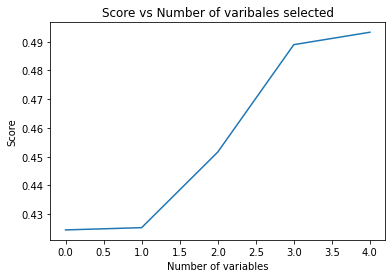

In [61]:
plt_plot(scores_list, 'Score vs Number of varibales selected','Number of variables', 'Score')

The r squared scores seem to be increasing for the selected investment features. The scores remain less that 0.4 probably because of the small number of features used

In [62]:
def final_inv_model(n, X_final_inv, y_final_inv):
    cols = list(X_INV.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, n)             
    #Transforming data using RFE
    x_fitted = rfe.fit_transform(X_final_inv,y_final_inv)  
    #Fitting the data to model
    model.fit(x_fitted,y_final_inv)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

In [63]:
selected_inv_features, inv_model, inv_rfe = final_inv_model(optimum_no_features, X_train_inv, y_train_inv)
selected_inv_features.tolist()

['foreignliabilitiestotalportfolioinvestment',
 'netinvestmentposition',
 'costprofitofrevaluationofforeignloans',
 'portfolioinvestmentassets',
 'directinvestmentinreportingeconomy']

In [64]:
y_train_inv_predicted = inv_model.predict(inv_rfe.transform((X_train_inv)))

## Residual Analysis

<AxesSubplot:xlabel='unemployment_rate'>

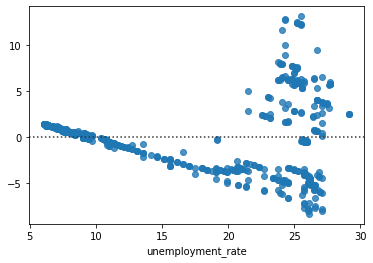

In [65]:
inv_residuals =y_train_inv.astype(float)- (y_train_inv_predicted)
sns.residplot(y_train_inv.astype(float),y_train_inv_predicted)

The residual points are not evenly dustributed vertically. The predictions get worse as the unemployment rate increases. The residuals show heteroscedasticity pattern which happens when regression assumes that the residuals come data with constant variance. This resuslts in low confidence in the model.

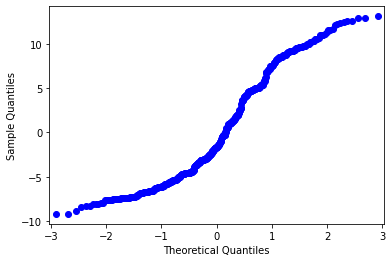

In [66]:
import statsmodels.api as sm
_ = sm.qqplot(inv_residuals)

<AxesSubplot:xlabel='unemployment_rate', ylabel='Density'>

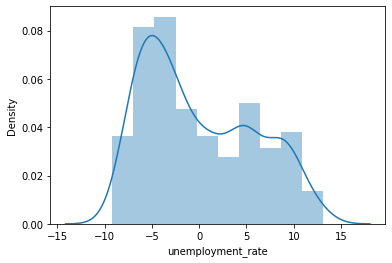

In [67]:
sns.distplot(inv_residuals)

The residuals are not normally distributed

In [68]:
formula_inv_features = ' + '.join(list(selected_inv_features))
formula_inv = 'unemployment_rate~'+ formula_inv_features

In [69]:
X_y_new_inv_train = pd.concat([X_train_inv,pd.DataFrame(y_train_inv)], axis=1)

In [70]:
X_train_y_target_INV = pd.concat([X_train_inv, pd.DataFrame(y_train_inv)], axis=1)

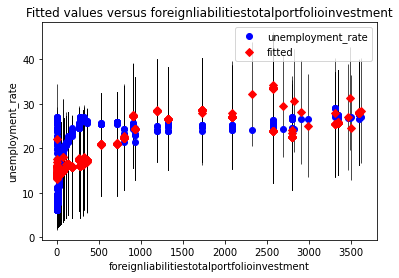

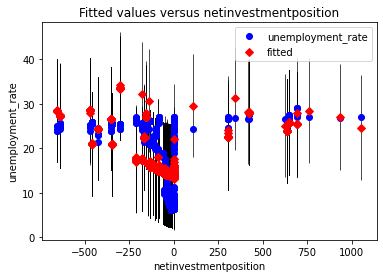

In [71]:
import statsmodels.formula.api as sm
results = sm.ols(formula=formula_inv,data = X_train_y_target_INV).fit()
import statsmodels.graphics as smgraphics

axss = smgraphics.regressionplots.plot_fit(results, 1)
_ = smgraphics.regressionplots.plot_fit(results, 2)

# Final Investment Model

In [72]:
import statsmodels.api as sm
final_inv_model = rlm(formula_inv, data=X_train_y_target_INV,
                      M=sm.robust.norms.HuberT()).fit()

In [73]:
final_inv_model_predicted = final_inv_model.predict(X_test_inv)
inv_params = np.array(final_inv_model.params)
metrics.r2_score(y_test_inv, final_inv_model_predicted)

0.4860998686031516

In [74]:
def print_p_values_inv(x_test, y_test, predicted, params):
    """
    Calculates the p value, based on https://stackoverflow.com/a/42677750/9260653
    """
    newX = np.append(np.ones((len(x_test),1)), x_test, axis=1)
    MSE = (sum((y_test.values-predicted)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)[:-1]

    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,4)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-Values"] = [params,sd_b,ts_b,p_values]
    print(myDF3.iloc[1])

In [75]:
# inv_params.shape
print_p_values_inv(X_test_inv, y_test_inv, final_inv_model_predicted, inv_params)


ValueError: operands could not be broadcast together with shapes (6,) (10,) 

With a p-value 0f less than 0.01 showing high significance, we can reject the hypothesis that investment has an effect on unemployment rate.

In [76]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The f value is " + str(fvalue[0][0]))

In [77]:
fstat_test(final_inv_model)
degresOfFreedom = len(X_train_inv) - (len(X_train_inv.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

The f value is 90.30033569702208


3.012290086049356

With a p-value 0f less than 0.01 and f value greater than f showing high significance, we can reject the hypothesis that investment has an effect on unemployment rate.

# Unemployement rate in SA: Exploring the multi-variables of cash flow in South Africa that affects the rate of unemployement

## 3. How does the government cash flow affect unemployment rate?

In [78]:
column_names = list()
for i in x_values_ffill:
    if 'cash' in i:
        column_names.append(i)
column_names #7

['Total cash-flow revenue',
 'Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government. ',
 'Consolidated general government: Net change in the stock of cash_x',
 'Cash received from the issuance of domestic government bonds less cash payments made to redeem domestic government bonds.',
 'The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. ',
 'Cash received from the issuance of foreign bonds and loans less cash payments made to redeem foreign bonds and loans.',
 'Cash received from the issuance of Treasury bills less cash payments made to redeem Treasury bills.',
 'The difference between cash-flow revenue and cash-flow expenditure._x',

### Function to select varables about cash flow
This helper function helps with selecting featues about the speific topic that needs to be researched

In [79]:

def get_features(s):
    df_new = list()

    for i in column_names:
        if s in i:
            df_new.append(x_values_ffill[i])
            print(i)
    return df_new

In [80]:
df_cash = get_features('cash') 
DF = pd.DataFrame(data = df_cash)

Total cash-flow revenue
Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government. 
Consolidated general government: Net change in the stock of cash_x
Cash received from the issuance of domestic government bonds less cash payments made to redeem domestic government bonds.
The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. 
Cash received from the issuance of foreign bonds and loans less cash payments made to redeem foreign bonds and loans.
Cash received from the issuance of Treasury bills less cash payments made to redeem Treasury bills.
The difference between cash-flow revenue and cash-flow expenditure._x
The difference between cash-flo

In [81]:
X_cash= DF.transpose()

correlated_features_cash = set()
correlation_matrix_cash = X_cash.corr()

for i in range(len(correlation_matrix_cash .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            colname = correlation_matrix_cash.columns[i]
            correlated_features.add(colname)
correlated_features_cash


set()

In [82]:
for col in X_cash.columns:
    new_w = wordopt(col)
    X_cash.rename(columns= {col: new_w.replace(' ', '')}, inplace = True)

Y_cash = df2['unemployment_rate']


### Data splitting

The predefined ratio used for data splitting is 70/30 reason being that I want to improve the accuracy of the evaluation of the model.

In [83]:
X_train_cash, X_test_cash, y_train_cash, y_test_cash = train_test_split(X_cash,Y_cash, test_size = 0.3, random_state = 0)

## Modeling - Stepwise regression



In [84]:
scores_list_cash, optimum_no_features_cash = model_fit(X_train_cash,y_train_cash)

0 0.006632037826124537
10 0.5543111898943884


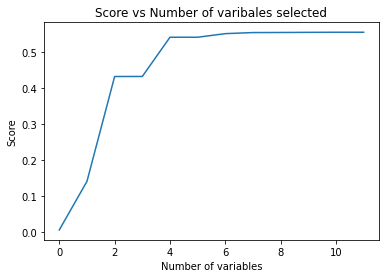

In [85]:
plt_plot(scores_list_cash, 'Score vs Number of varibales selected','Number of variables', 'Score')

In [86]:
# fit final model using optimum number of features from prev function

def final_model_cash(optimum_no_features, X_train, y_train):
    cols = list(X_cash.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, optimum_no_features)             
    #Transforming data using RFE
    x_fitted = rfe.fit_transform(X_train,y_train)  
    #Fitting the data to model
    model.fit(x_fitted,y_train)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

In [87]:
selected_features_cash, model_cash, rfe_cash = final_model(optimum_no_features, X_train_cash, y_train_cash)

TypeError: 'RLMResultsWrapper' object is not callable

In [88]:
y_train_predicted_cash = model_cash.predict(rfe_cash.transform((X_train_cash)))


NameError: name 'model_cash' is not defined

## Model Fit Analaysis

# Post-Stepwise Regression

## Residual Analysis

In [ ]:
residuals = y_train_cash-y_train_predicted_cash

In [ ]:
sns.residplot(y_train_cash,y_train_predicted_cash)

### We can apply normal probability plot to assess how the data (error) depart from normality visually:


In [ ]:
formula_features_cash = ' + '.join(list(selected_features_cash))
formula_cash = 'unemployment_rate~'+ formula_features_cash

In [ ]:
# Add y back to df
X_y_new_train_cash = pd.concat([X_train_cash,pd.DataFrame(y_train_cash)], axis=1)

In [ ]:
X_train_y_target_cash = pd.concat([X_train_cash, pd.DataFrame(y_train_cash)], axis=1)
# X_train_y_target

In [ ]:
import statsmodels.graphics as smgraphics
import statsmodels.formula.api as sm
results_cash = sm.ols(formula=formula_cash,data = X_train_y_target_cash).fit()
axss_cash = smgraphics.regressionplots.plot_fit(results_cash,3)
_ = smgraphics.regressionplots.plot_fit(results_cash,2)

In [ ]:
Y_ols_pred_cash=results_cash.predict(X_train_cash)

In [ ]:
residuals_cash = y_train_cash - Y_ols_pred_cash


In [ ]:
fig, ax1 = plt.subplots(figsize=(6,2.5))
_ = ax1.scatter(X_train_cash.iloc[:,5:6], residuals_cash)

In [ ]:
sns.distplot(residuals)

In [ ]:
import statsmodels.api as sm
_ = sm.qqplot(residuals_cash)

### Outlier Detection and removal
Here outliers are detected and deleted and used the remaining observations for fitting the model.

In [ ]:
test_cash = results.outlier_test()
outliers_cash = ((x[i],y[i]) for i,t in enumerate(test) if t[2] < 0.5)

In [ ]:
X_train_cash, X_test_cash, y_train_cash, y_test_cash = train_test_split(X_cash,Y_cash, test_size = 0.3, random_state = 0)


In [ ]:
outliers_cash =(i for i,t in enumerate(test.iloc[:,2]) if t < 0.5)

In [ ]:
# Index of Outliers
outliers_list_cash = list(outliers)


In [ ]:
# Remove outliers
X_train_cash = pd.DataFrame(np.delete(X_train_cash.values, outliers_list_cash,0))
y_train_cash = pd.DataFrame(np.delete(y_train_cash.values, outliers_list_cash,0))


## Final Model


In [ ]:
X_train_cash, X_test_cash, y_train_cash, y_test_cash = train_test_split(X_cash,Y_cash, test_size = 0.3, random_state = 0)

final_model_cash = rlm(formula_cash, data=X_train_y_target_cash,
                      M=sm.robust.norms.HuberT()).fit()

In [ ]:
final_model_predicted_cash = final_model_cash.predict(X_test_cash)

In [ ]:
params_cash = np.array(final_model_cash.params)

In [ ]:
metrics.r2_score(y_test, final_model_predicted)

In [ ]:
print_p_values(X_test_cash, y_test_cash, final_model_predicted_cash, params_cash)


he test for $H_{0}$ byusing the following statistic:
$$
F_{0} = \frac{MS_R}{MS_E}
$$
where $MS_R$ is the regression mean square and $MS_E$ is the error mean square.
<br>
The null hypothesis, $H_{0}$, is rejected if the calculated statistic. $f_{0}, is usch that$
$$
F_{0} > f
$$
I will now test my hypothesist using $F$

In [ ]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The fvalue is " + str(fvalue[0][0]))

In [ ]:
fstat_test(final_model)

In [ ]:
degresOfFreedom = len(X_train) - (len(X_train.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

As shown above, $F_{0} = 110.5337$ and $f = 3.004779$.
<br>
<br>
Since $F_0$ > $f$, $H_{0}$ is rejected and it is concluded that at least one $\beta_{i}$ cofficient is significant. In other words, it is concluded that a regression model exists between the exploratory and response variables

# Unemployement rate in SA: Exploring the relationship between multiple variables that may influence the unemployment rate of South Africa

## How does the government debt affect unemployment rate?

In [ ]:
predictors = x_values_ffill
DF_Y = y_values_ffill

In [ ]:
def get_features(s):
    df_new = pd.DataFrame()

    for i in predictors:        
        if s in i:
            df_new[i] = predictors[i]

    return df_new

In [ ]:
df_new_1 = get_features('debt')
df_new_2 = get_features('outstanding')
df = pd.concat([df_new_1 , df_new_2 , DF_Y], axis=1)

# Exploratory Plots

In [ ]:
sns.heatmap(df.corr())

# Colinearity

In [ ]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

In [ ]:
# removing all the corrated values with a correlation value over 0.7
DF_X = df.copy()
correlation(DF_X,0.7)

In [ ]:
values = list(DF_X.columns)
keys = list('ABCDEFGH')

zip1 = zip(keys, values)



dictionary = dict(zip1)


print(dictionary)

In [ ]:
DF_X.columns = keys
DF_Y.columns = ['unemployment_rate']

# Modelling
## Stepwise regression

In [ ]:
X_train_debt, X_test_debt, y_train_debt, y_test_debt = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)


In [ ]:
# Train model using X_train, y_train
X_train_debt
scores_list_debt, optimum_no_features_debt = model_fit(X_train_debt,y_train_debt)

In [ ]:
plt_plot(scores_list_debt, 'Score vs Number of varibales selected','Number of variables', 'Score')

In [ ]:
selected_features_debt, model_debt, rfe_debt = final_model(optimum_no_features_debt, X_train_debt, y_train_debt)

In [ ]:
y_train_predicted_debt = model.predict(rfe_debt.transform((X_train_debt)))


## Model Fit Analaysis

# Post-Stepwise Regression

## Residual Analysis


In [ ]:
residuals_debt = y_train_debt-y_train_predicted_debt
residuals_debt

In [ ]:
ax = sns.residplot(y_train_debt,y_train_predicted_debt)

In [ ]:
### We can apply normal probability plot to assess how the data (error) depart from normality visually:

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
formula_features_debt = ' + '.join(list(selected_features_debt))
formula_debt = 'unemployment_rate~'+ formula_features_debt

In [ ]:
# Add y back to df

X_y_new_train_debt = pd.concat([X_train_debt, y_train_debt], axis=1)

In [ ]:
X_train_y_target_debt = pd.concat([X_train_debt, y_train_debt], axis=1)

In [ ]:
results_debt = sm.ols(formula=formula,data = X_train_y_target_debt).fit()
import statsmodels.graphics as smgraphics

axss = smgraphics.regressionplots.plot_fit(results_debt, 1)
_ = smgraphics.regressionplots.plot_fit(results_debt,5)


In [ ]:
Y_ols_pred_debt=results.predict(X_train_debt)
Y_ols_pred_debt = pd.DataFrame(Y_ols_pred_debt)
Y_ols_pred_debt.columns = ['unemployment_rate']

In [ ]:
pred_val_debt = results_debt.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(6,2.5))

residuals.shape
_ = ax.scatter(pred_val_debt, residuals_debt)

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,2.5))
_ = ax1.scatter(X_train_debt.iloc[:,5:6], residuals_debt)

In [ ]:
# Plot shows that the residuals are normally distributed
sns.distplot(residuals)

In [ ]:
import statsmodels.api as sm
_ = sm.qqplot(residuals)

### Outlier Detection and removal

In [ ]:
test_debt = results_debt.outlier_test()
outliers_debt = ((x[i],y[i]) for i,t in enumerate(test_debt) if t[2] < 0.5)

In [ ]:
X_train_debt, X_test_debt, y_train_debt, y_test_debt = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)

In [ ]:
outliers_debt =(i for i,t in enumerate(test.iloc[:,2]) if t < 0.5)

In [ ]:
# Index of Outliers
outliers_list_debt = list(outliers_debt)

In [ ]:
# Remove outliers
X_train_debt = pd.DataFrame(np.delete(X_train_debt.values, outliers_list_debt,0))
y_train_debt = pd.DataFrame(np.delete(y_train_debt.values, outliers_list_debt,0))
len(X_train_debt)

## Final Model

In [ ]:
X_train_debt, X_test_debt, y_train_debt, y_test_debt = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)

final_model_debt = rlm(formula, data=X_train_y_target_debt,
                      M=sm.robust.norms.HuberT()).fit(conv="weights")

In [ ]:
X_train_debt

In [ ]:
final_model_predicted_debt = final_model.predict(X_test_debt)

In [ ]:
params_debt = np.array(final_model_debt.params_debt)

In [ ]:
metrics.r2_score(y_test_debt, final_model_predicted_debt)

In [ ]:
print_p_values(X_test_debt, y_test_debt, final_model_predicted_debt, params_debt)

 The test for $H_{0}$ byusing the following statistic:
$$
F_{0} = \frac{MS_R}{MS_E}
$$
where $MS_R$ is the regression mean square and $MS_E$ is the error mean square.
<br>
The null hypothesis, $H_{0}$, is rejected if the calculated statistic. $f_{0}, is usch that$
$$
F_{0} > f
$$
I will now test my hypothesist using $F$

In [ ]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The fvalue is " + str(fvalue[0][0]))

In [ ]:
fstat_test(final_model_debt)

In [ ]:
degresOfFreedom = len(X_train) - (len(X_train_debt.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

As shown above, $F_{0} = 304.572$ and $f = 3.01217$.
<br>
<br>
Since $F_0$ > $f$, $H_{0}$ is rejected and it is concluded that at least one $\beta_{i}$ cofficient is significant. In other words, it is concluded that a regression model exists between the exploratory and response variables

# Conlcusion
